In [3]:
import os
os.chdir("..")

In [4]:
from utils import data as data_utils
import torch_geometric as pyg
from utils import ZincWithRDKit
from datasets import DatasetDict, load_from_disk, IterableDataset
from os.path import join
import subprocess
from utils import graphormer_data_collator_improved as graphormer_collator_utils
from tqdm import tqdm
import numpy as np
import time
import yaml

from utils.modeling_graphormer_improved import (
    BetterGraphormerConfig,
    GraphormerForPretraining,
    GraphormerForGraphClassification,
)

import torch
import matplotlib.pyplot as plt

/home/alexander/miniconda3/envs/pgt_hug/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
config_file_path = "configs/pcqm4mv2_pretraining_run.yml"
pretrained_model_checkpoint = "important_checkpoints/pcqm4mv2_checkpoint_408000steps"

In [6]:
dataset_path =  "data/ZINC/processed/arrow"
#dataset_path =  "data/ZINC/processed/arrow_processed"
dataset = DatasetDict.load_from_disk(
    dataset_path, keep_in_memory=False
)

In [7]:
example_batch = [dataset["train"][i] for i in range(512)]


In [8]:
with open(config_file_path, "r") as file:
        config = yaml.safe_load(file)

In [9]:
model = GraphormerForPretraining.from_pretrained(pretrained_model_checkpoint).to("cuda")

collator = graphormer_collator_utils.GraphormerDataCollator(model_config = BetterGraphormerConfig(**config["model_args"]), on_the_fly_processing=True, collator_mode= "pretraining")

In [10]:
collated_batch = collator(example_batch)
collated_batch = {k: v.to("cuda") for k, v in collated_batch.items() if isinstance(v, torch.Tensor)}


In [11]:
res = model(**collated_batch)

In [12]:
atom_logits = res["decoded_masked_outputs_logits"][:,:,0]

In [13]:
mean_probs = torch.softmax(atom_logits, dim=-1).mean(dim=0)

In [14]:
np_mean_probs = mean_probs.detach().cpu().numpy()

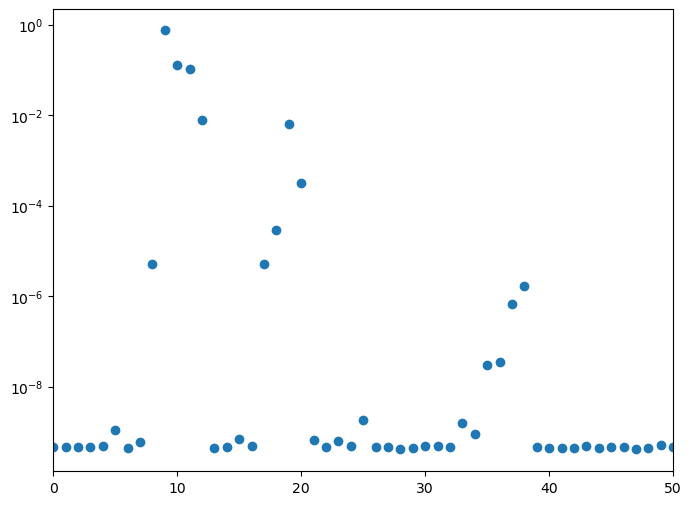

In [15]:
indices = np.arange(np_mean_probs.size)

# Create a discrete plot
plt.figure(figsize=(8, 6))
plt.scatter(indices, np_mean_probs)
plt.xlim(0, 50)
plt.yscale("log")
plt.show()

In [16]:
np.argsort(np_mean_probs)[-20:][::-1] -3 

array([ 6,  7,  8,  9, 16, 17, 15, 14,  5, 35, 34, 33, 32, 22, 30,  2, 31,
       12, 18, 20])

In [17]:
true_atoms = (collated_batch["labels"][:,0] - 3).detach().cpu().numpy()

In [18]:
unique_elements, counts = np.unique(true_atoms, return_counts=True)
probabilities = counts / true_atoms.size

# Print out probabilities
for element, prob in zip(unique_elements, probabilities):
    print(f"Element {element}: Probability {prob} - Predicted Probability {np_mean_probs[element + 3]}")

Element 6: Probability 0.7232441471571907 - Predicted Probability 0.7556486129760742
Element 7: Probability 0.12959866220735786 - Predicted Probability 0.12656907737255096
Element 8: Probability 0.1020066889632107 - Predicted Probability 0.10341334342956543
Element 9: Probability 0.014214046822742474 - Predicted Probability 0.007710593286901712
Element 16: Probability 0.023411371237458192 - Predicted Probability 0.006291940342634916
Element 17: Probability 0.007525083612040134 - Predicted Probability 0.000324172229738906




Atom Property Index: 0



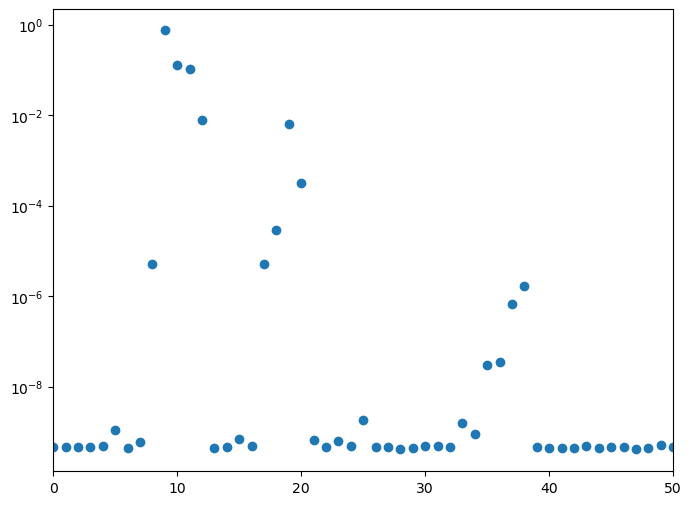

Element 6: Probability 0.7232441471571907 - Predicted Probability 0.7556486129760742
Element 7: Probability 0.12959866220735786 - Predicted Probability 0.12656907737255096
Element 8: Probability 0.1020066889632107 - Predicted Probability 0.10341334342956543
Element 16: Probability 0.023411371237458192 - Predicted Probability 0.006291940342634916
Element 9: Probability 0.014214046822742474 - Predicted Probability 0.007710593286901712
Element 17: Probability 0.007525083612040134 - Predicted Probability 0.000324172229738906
Remaining Predicted Probability: 4.226036253385246e-05


Atom Property Index: 1



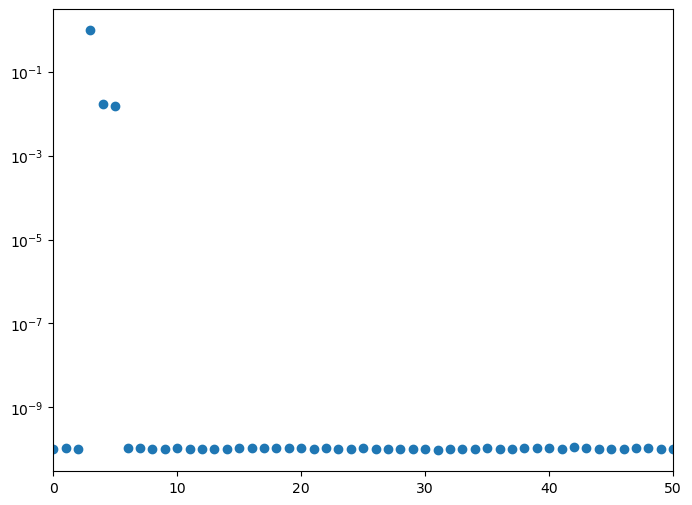

Element 0: Probability 1.0 - Predicted Probability 0.9681155681610107
Remaining Predicted Probability: 0.03188443183898926


Atom Property Index: 2



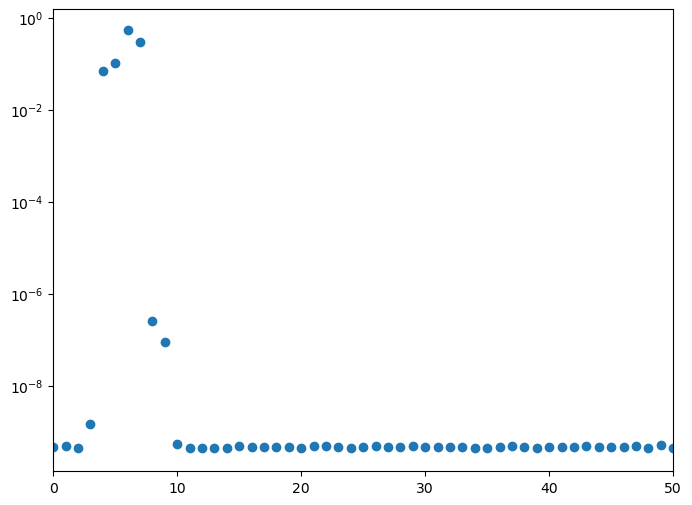

Element 3: Probability 0.5209030100334449 - Predicted Probability 0.5353487133979797
Element 4: Probability 0.28678929765886285 - Predicted Probability 0.2935025990009308
Element 1: Probability 0.09949832775919733 - Predicted Probability 0.06904838234186172
Element 2: Probability 0.09280936454849498 - Predicted Probability 0.10209973901510239
Remaining Predicted Probability: 5.662441253662109e-07


Atom Property Index: 3



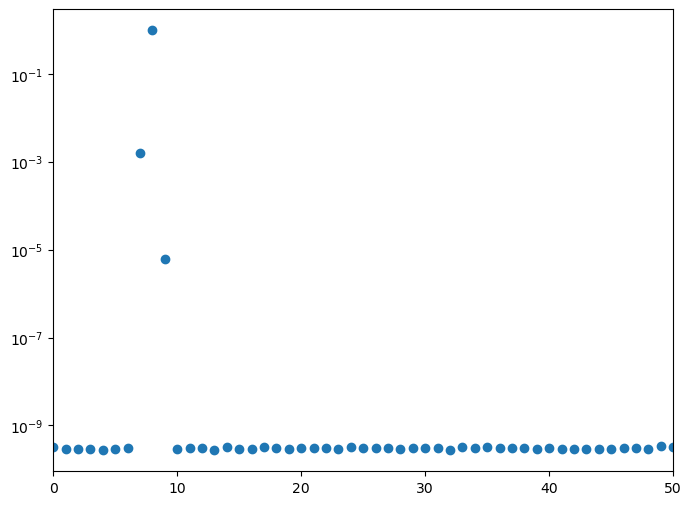

Element 5: Probability 0.9765886287625418 - Predicted Probability 0.998429000377655
Element 6: Probability 0.017558528428093644 - Predicted Probability 6.178216153784888e-06
Element 4: Probability 0.005852842809364548 - Predicted Probability 0.001564684440381825
Remaining Predicted Probability: 1.3696580936084501e-07


Atom Property Index: 4



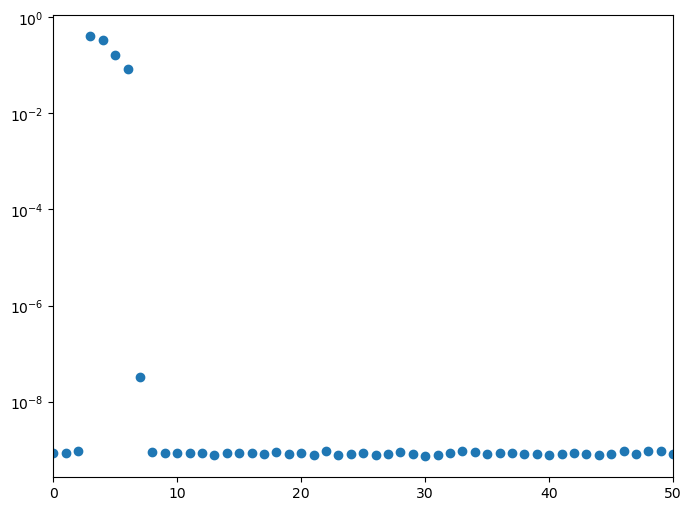

Element 0: Probability 0.431438127090301 - Predicted Probability 0.4033981263637543
Element 1: Probability 0.33612040133779264 - Predicted Probability 0.3448565900325775
Element 2: Probability 0.1596989966555184 - Predicted Probability 0.168140709400177
Element 3: Probability 0.07274247491638795 - Predicted Probability 0.0836041271686554
Remaining Predicted Probability: 4.470348358154297e-07


Atom Property Index: 5



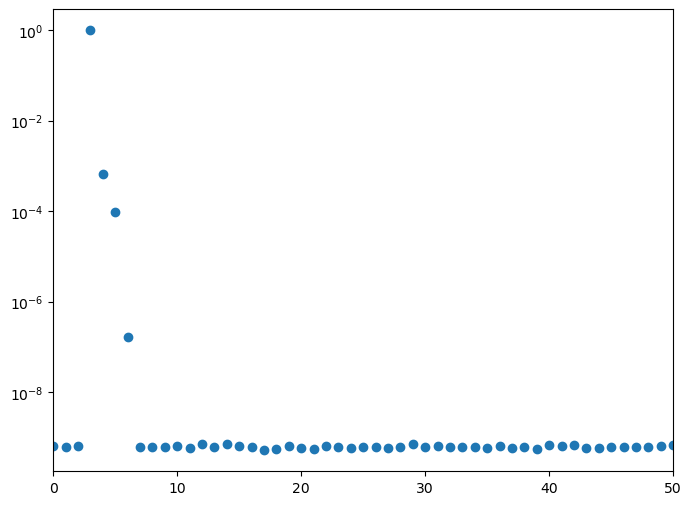

Element 0: Probability 1.0 - Predicted Probability 0.9992302060127258
Remaining Predicted Probability: 0.0007697939872741699


Atom Property Index: 6



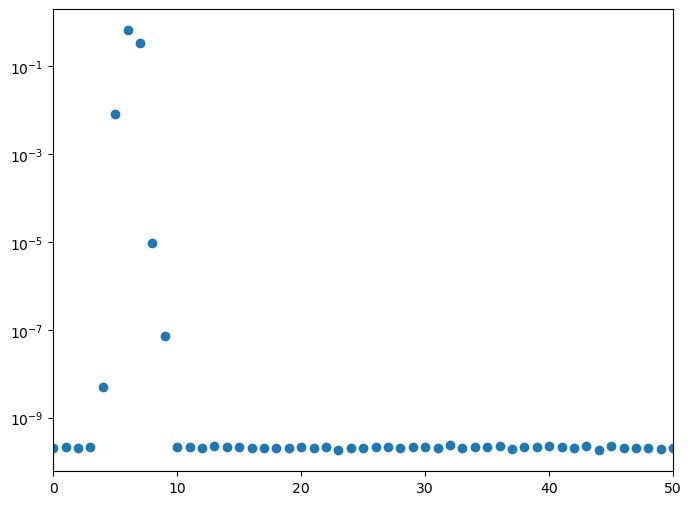

Element 3: Probability 0.6538461538461539 - Predicted Probability 0.6538741588592529
Element 4: Probability 0.3377926421404682 - Predicted Probability 0.33775439858436584
Element 2: Probability 0.008361204013377926 - Predicted Probability 0.008361879736185074
Remaining Predicted Probability: 9.562820196151733e-06


Atom Property Index: 7



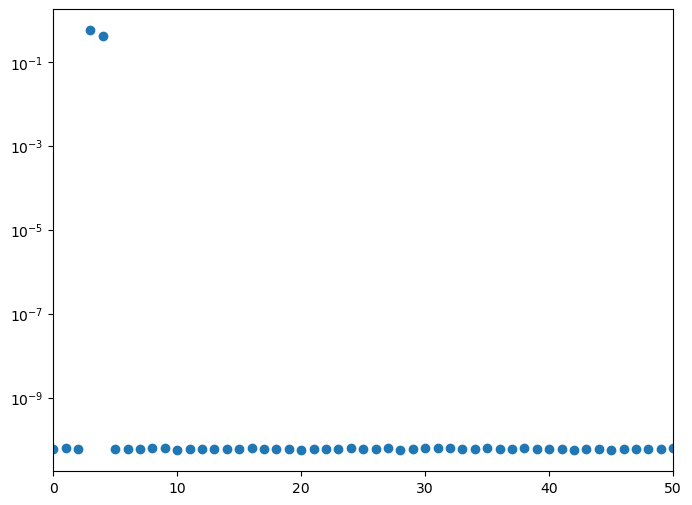

Element 0: Probability 0.5735785953177257 - Predicted Probability 0.573515772819519
Element 1: Probability 0.42642140468227424 - Predicted Probability 0.42648422718048096
Remaining Predicted Probability: 0.0


Atom Property Index: 8



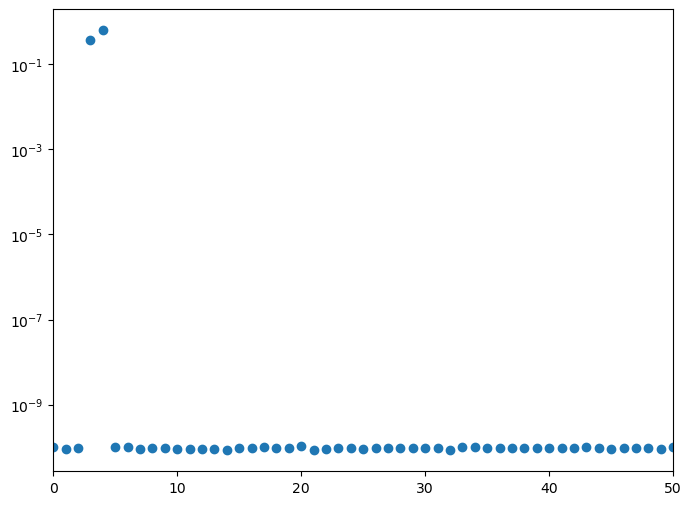

Element 1: Probability 0.6237458193979933 - Predicted Probability 0.622761607170105
Element 0: Probability 0.3762541806020067 - Predicted Probability 0.377238392829895
Remaining Predicted Probability: 0.0


In [19]:
decoded_masked_output_logits = res["decoded_masked_outputs_logits"]
for atom_property_index in range(decoded_masked_output_logits.shape[-1]):
    print(f"\n\nAtom Property Index: {atom_property_index}\n")

    atom_logits = decoded_masked_output_logits[:,:,atom_property_index]
    mean_probs = torch.softmax(atom_logits, dim=-1).mean(dim=0)
    np_mean_probs = mean_probs.detach().cpu().numpy()

    indices = np.arange(np_mean_probs.size)

    # Create a discrete plot
    plt.figure(figsize=(8, 6))
    plt.scatter(indices, np_mean_probs)
    plt.xlim(0, 50)
    plt.yscale("log")
    plt.show()

    np.argsort(np_mean_probs)[-20:][::-1] -3 
    true_atoms = (collated_batch["labels"][:,atom_property_index] - 3).detach().cpu().numpy()

    unique_elements, counts = np.unique(true_atoms, return_counts=True)
    probabilities = counts / true_atoms.size

    sorted_indices = np.argsort(probabilities)[::-1]

    unique_elements = unique_elements[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Print out probabilities
    acc_prob = 0
    for element, prob in zip(unique_elements, probabilities):
        print(f"Element {element}: Probability {prob} - Predicted Probability {np_mean_probs[element + 3]}")
        acc_prob += np_mean_probs[element + 3]

    print(f"Remaining Predicted Probability: {1 - acc_prob}")